# Deep Q-Network for Cartpole-v1 problem

### import dependencies

In [1]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

Using TensorFlow backend.


### define the Deep Q-Network Agent

In [2]:
class DQNagent:
    def __init__(self, state_size, action_size, nn_architecture):
        """initialize instance variables and build model"""
        
        ## parameters
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=memory_len)
        self.gamma = gamma    # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate

        ## the Q-network
        self.modelQ = Sequential()
        for ih in range(len(nn_architecture)):
            if ih == 0:
                self.modelQ.add(Dense(nn_architecture[ih], input_dim=self.state_size, activation='relu'))
            self.modelQ.add(Dense(nn_architecture[ih], activation='relu'))
        self.modelQ.add(Dense(self.action_size, activation='linear'))        
        self.modelQ.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        ## the Qhat-network
        self.modelQhat = Sequential()
        for ih in range(len(nn_architecture)):
            if ih == 0:
                self.modelQhat.add(Dense(nn_architecture[ih], input_dim=self.state_size, activation='relu'))
            self.modelQhat.add(Dense(nn_architecture[ih], activation='relu'))
        self.modelQhat.add(Dense(self.action_size, activation='linear'))        
        self.modelQhat.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

    def remember(self, state, action, reward, next_state, done):
        """append the most recent SARS sequence to the memory"""
        self.memory.append([state, action, reward, next_state, done])
        
    def act(self, state, epsilon):
        """with probability epsilon, select random action, otherwise use the DQN prediction"""
        if np.random.uniform(0,1) < self.epsilon:
            return np.random.randint(0, self.action_size)
        else:
            return np.argmax(self.modelQ.predict(state, batch_size=None, verbose=0, steps=None))
    
    def replay(self, batch_size):
        """experience replay: note: this does not seem to line up with the description in the paper..."""
        x_batch, y_batch = [], []
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            x_batch.append(state[0]) 
            y_target = self.modelQ.predict(state)
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.modelQ.predict(next_state)[0])
            y_batch.append(y_target[0])
        
        self.modelQ.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def set_weights_equal(self):
        """set the weights of the Qhat-network to be the same as the Q-network"""
        self.modelQhat.set_weights(self.modelQ.get_weights())
        
    def load(self, name):
        """load the weights of a previously trained Q-network"""
        self.modelQ.load_weights(name)
        self.modelQhat.load_weights(name)
        
    def save(self, name):
        """save the weights of the Q network"""
        self.modelQ.save_weights(name)

### hyperparameters

In [3]:
n_epsiodes = 1000
max_timesteps = 1000

memory_len = 2000
memory_batch_size = 32

gamma = 0.95

learning_rate = 0.001

epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01

nn_architecture = [24, 24] #number of units in the hidden layers

In [4]:
## initializations
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNagent(state_size, action_size, nn_architecture)
agent.set_weights_equal()

## loop over episodes
time_list = []
reward_list = []
for e in range(n_epsiodes):
    state = np.reshape(env.reset(), [1, state_size])
    
    ## loop over timesteps
    done = False
    for time in range(max_timesteps):
        if not done:
            
            ## make the next action
            action = agent.act(state, epsilon)

            ## find the next state, reward, and done status                
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            
            ## store the transition into memory
            agent.remember(state, action, reward, next_state, done)
            
            ## advance the state
            state = next_state
            
            ## train the network using experience replay
            agent.replay(memory_batch_size)
        
        else:
            reward_list.append(reward)
            time_list.append(time)
            break

## save
#agent.save("trained_models/dummy")
print(time_list)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


KeyboardInterrupt: 

From CartPole-v0: "CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials."

average reward over last 100 trials:  189.42


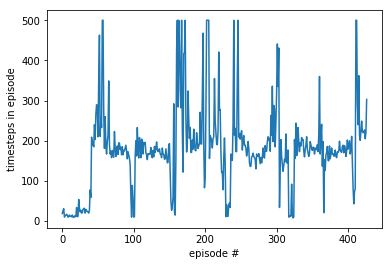

In [5]:
print("average reward over last 100 trials: ",np.mean(np.asarray(time_list[-101:-1])))
plt.plot(time_list)
plt.xlabel("episode #")
plt.ylabel("timesteps in episode")
plt.show()